<a href="https://colab.research.google.com/github/NeerajSahani/Generative-Adversarial-Networks/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import os
import time
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype(np.float_)
train_images = (train_images - 127.5) / 127.5

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def get_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), use_bias=True, padding='same')) # -> (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=True, padding='same')) # -> (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), use_bias=True, padding='same', activation='tanh' )) # -> (None, 28, 28, 1)
  return model

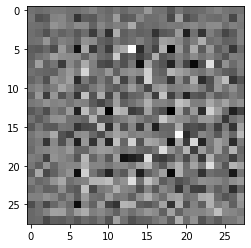

In [7]:
generator = get_generator()
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0, :, :, 0], cmap='gray')

In [8]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model


In [9]:
discriminator = get_discriminator()
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[-0.00153488]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total = real_loss + fake_loss
  return total

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer, 
    generator=generator, 
    discriminator=discriminator
    )

In [14]:
EPOCHS = 100
noise_dim = 100
num_samples_to_generate = 16
seed = tf.random.normal([num_samples_to_generate, noise_dim])

In [15]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)

    generate_and_save_images(generator, epoch+1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  #Final Output
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)



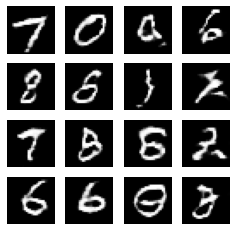

In [18]:
train(dataset=train_dataset, epochs=EPOCHS)

In [19]:
noise = tf.random.normal([1, 100])

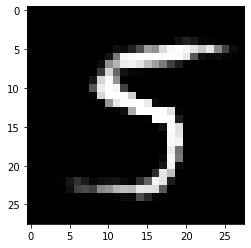

In [25]:
noise = tf.random.normal([1, 100])
img = generator(noise, training=False)
plt.imshow(img[0, :, :, 0], cmap='gray')